# StyleGAN Latent Embedding Image Reconstruction

In [1]:
import torch
from torch.nn import DataParallel
from torchvision.utils import save_image
from pathlib import Path
from PIL import Image
import argparse
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipyfilechooser import FileChooser
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

from src.model import EmbeddingModel
from src.dataset import Images
from src.utils import show_img

## Configure Model Settings

In [2]:
kwargs = {
    'output_dir': 'data/output',       # Output path              
    'seed': None,                      # Random seed
    'loss_l2': 1,                      # L2 loss weight
    'loss_l1': 0,                      # L1 loss weight
    'loss_geocross': 0,                # Geocross loss weight
    'noise_type': 'trainable',         # trainable, fixed or zero
    'num_trainable_noise_layers': 18,  # Up to what noise layer is trainable (max: 18)      
    'tile_latent': False,              # Use the same latent code at each layer
    'bad_noise_layers': '17',          # List of zeroed noise layers
    'optim': 'adam',                   # adam, sgd, sgdm or adamax
    'learning_rate': 0.4,              # Learning rate
    'steps': 500,                      # Number of optimization steps
    'lr_schedule': 'linear1cycledrop', # Learning rate schedule      
    'save_intermediate': False         # Save image after each step 
}

## Load Image

In [3]:
# File selection dialogue
fc = FileChooser('.')
display(fc)

FileChooser(path='.', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden='False',…

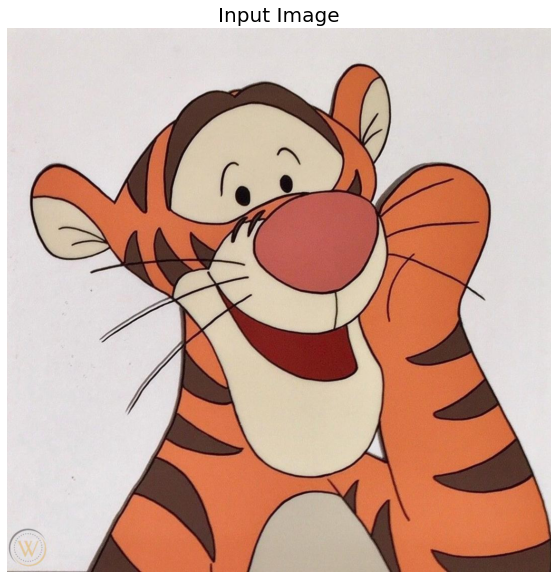

In [4]:
# Load image
path = fc.selected_path
input_img, input_img_name = Images(path)[0]
input_img = input_img.unsqueeze(0)

# Show input image
input_img_np = input_img.squeeze(0).permute(1,2,0).numpy()
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Input Image', fontsize=20)
plt.imshow(input_img_np)
plt.show()

## Run Model

In [5]:
model = DataParallel(EmbeddingModel(cache_dir='cache'))
output, = model(input_img, **kwargs)

  0%|          | 0/500 [00:00<?, ?it/s]

Loading Synthesis Network
Optimizing...


L2: 0.0000752247: 100%|██████████| 500/500 [02:06<00:00,  3.97it/s]

L2: 0.000075 | TOTAL: 0.000075 | time: 126.1 | it/s: 3.97


## Show Output

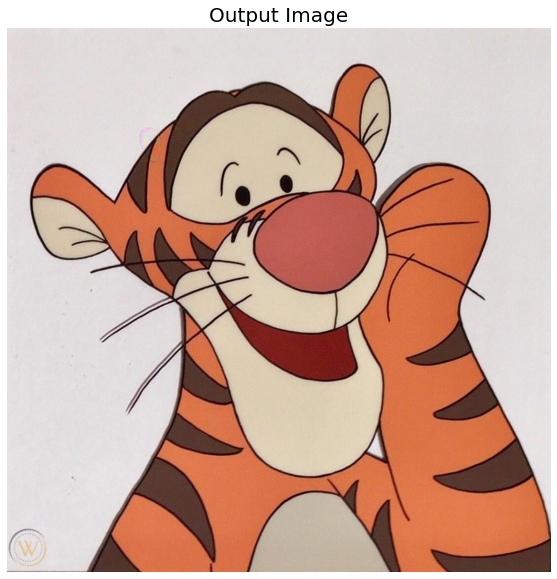

In [6]:
output_img_np = output[0].squeeze(0).permute(1,2,0).numpy()
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Output Image', fontsize=20)
plt.imshow(output_img_np)
plt.show()

## Reconstruction Error

Reconstruction Metrics Results:
PSNR: 41.27837440908521
MSE: 7.45010783833929e-05
MAE: 0.004814229267729194


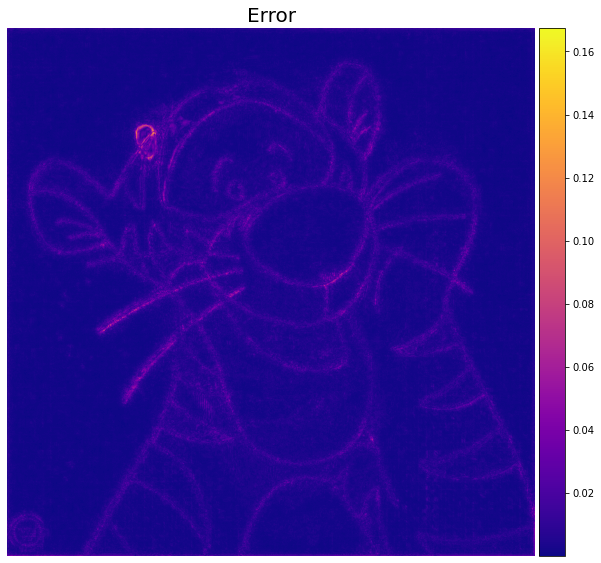

In [7]:
# Calculate metrics
def mae(img1, img2):
    return np.mean(np.abs(img1 - img2), dtype=np.float64)

print('Reconstruction Metrics Results:')
print(f'PSNR: {peak_signal_noise_ratio(input_img_np, output_img_np)}')
print(f'MSE: {mean_squared_error(input_img_np, output_img_np)}')
print(f'MAE: {mae(input_img_np, output_img_np)}')

# Visualize error
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Error', fontsize=20)
ax = plt.gca()
im = ax.imshow(np.mean(np.abs(input_img_np-output_img_np), axis=2), alpha=1, cmap='plasma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Save Output

In [8]:
# Setup output paths
out_path = Path(kwargs['output_dir'])
out_path.mkdir(parents=True, exist_ok=True)

# Save image
save_image(output[0], f'{out_path}/{input_img_name}.png')